<a href="https://colab.research.google.com/github/EECR/Hello-World/blob/master/Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (you could download the notebook with File -> Download .ipynb, open the notebook locally, and then File -> Download as -> PDF via LaTeX), and then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
from scipy.io import loadmat
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images.

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The train and test datasets required for this project can be downloaded from [here](http://ufldl.stanford.edu/housenumbers/train.tar.gz) and [here](http://ufldl.stanford.edu/housenumbers/test.tar.gz). Once unzipped, you will have two files: `train_32x32.mat` and `test_32x32.mat`. You should store these files in Drive for use in this Colab notebook.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Load the dataset from your Drive folder

train = loadmat('/content/gdrive/My Drive/train_32x32.mat')
test = loadmat('/content/gdrive/My Drive/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [4]:
# Extracting the training and testing images and labels separately

x_train = train['X']
y_train = train['y']
x_test = test['X']
y_test = test['y']

x_train = tf.transpose(x_train, [3, 0, 1, 2])
x_test = tf.transpose(x_test, [3, 0, 1, 2])

x_train = np.array(x_train)
x_test = np.array(x_test)

# Checking shape of training and testing images
print(x_train.shape)
print(x_test.shape)

# (73257, 32, 32, 3)
# (26032, 32, 32, 3)

(73257, 32, 32, 3)
(26032, 32, 32, 3)


In [5]:
# Normalizing training and testing images

x_train = x_train / 255.
x_test = x_test / 255.


In [6]:
# Converting label 10 to 0

for y in range(len(y_train)):
    if y_train[y] == 10:
        y_train[y] = 0
        
for y in range(len(y_test)):
    if y_test[y] == 10:
        y_test[y] = 0
        


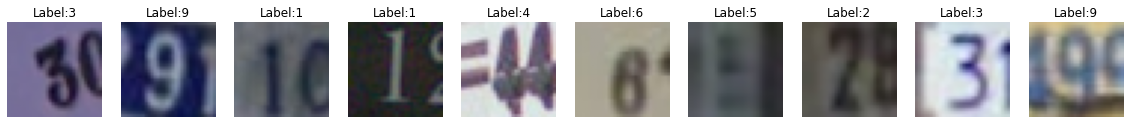

In [7]:
# Displaying 10 random images

num_x_train = x_train.shape[0]

random_inx = np.random.choice(num_x_train, 10)
random_x_train = x_train[random_inx, ...]
random_y_train = y_train[random_inx, ...]

fig, ax = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    
    ax[i].set_axis_off()
    ax[i].set_title(f'Label:{int(random_y_train[i])}')
    ax[i].imshow(random_x_train[i])
    

In [8]:
# Taking average across dim 2(coulor scale).  Keepdims=True. Axis 2 now have size 1.

x_train = np.mean(x_train, axis=3, keepdims=True)
x_test = np.mean(x_test, axis=3, keepdims=True)

# Checking the shape of training and testing images
print(x_train.shape)
print(x_test.shape)

# (73257, 32, 32, 1)
# (26032, 32, 32, 1)

(73257, 32, 32, 1)
(26032, 32, 32, 1)


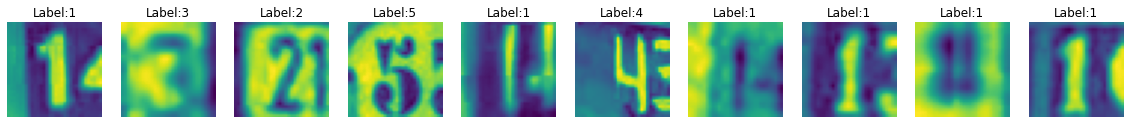

In [9]:
# Displaying 10 random images after reshape

num_x_train = x_train.shape[0]

random_inx = np.random.choice(num_x_train, 10)
random_x_train = x_train[random_inx, ...]
random_y_train = y_train[random_inx, ...]

fig, ax = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    
    ax[i].set_axis_off()
    ax[i].set_title(f'Label:{int(random_y_train[i])}')
    ax[i].imshow(random_x_train[i, :, :, 0])
    

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [10]:
# Building the MLP Model

def get_MLP_model(input_shape):
    model = Sequential([
        tf.keras.Input(shape=input_shape),
        Flatten(name='flatten'),
        Dense(units=64, activation='relu', name='dense_1'),
        Dense(units=128, activation='relu', name='dense_2'),
        Dense(units=64, activation='relu', name='dense_3'),
        Dense(units=10, activation='softmax', name='dense_4')
        ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [11]:
# Creating an instance of the model and show model summary

model = get_MLP_model(x_train[0].shape)
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                65600     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total params: 82,826
Trainable params: 82,826
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Creating Tensorflow checkpoints objects functions

def get_checkpoint_every_epoch():
    checkpoint_every_epoch_path = 'checkpoints_every_epoch/checkpoint'
    checkpoint_every_epoch = ModelCheckpoint(filepath=checkpoint_every_epoch_path,
                                             frequency='epoch',
                                             save_weights_only=True,
                                             verbose=1)
    return checkpoint_every_epoch


def get_checkpoint_best_only():    
    checkpoint_best_only_path = 'checkpoints_best_only/checkpoint'
    checkpoint_best_only = ModelCheckpoint(filepath=checkpoint_best_only_path,
                                           save_weights_only=True,
                                           save_freq='epoch',
                                           monitor='val_accuracy',
                                           save_best_only=True,
                                           verbose=1)
    return checkpoint_best_only


In [13]:
# Training the model

def train_model(model, x_train, y_train, epochs, batch_size, callbacks):
    history = model.fit(x_train, y_train, epochs=epochs,
                        validation_split = 0.15, batch_size = batch_size, callbacks=callbacks, verbose = 2)
    return history

callbacks = [get_checkpoint_every_epoch(), get_checkpoint_best_only()]
history = train_model(model, x_train, y_train, epochs=30, batch_size=128, callbacks=callbacks)

Epoch 1/30

Epoch 00001: saving model to checkpoints_every_epoch/checkpoint

Epoch 00001: val_accuracy improved from -inf to 0.45182, saving model to checkpoints_best_only/checkpoint
487/487 - 1s - loss: 2.0439 - accuracy: 0.2704 - val_loss: 1.6054 - val_accuracy: 0.4518
Epoch 2/30

Epoch 00002: saving model to checkpoints_every_epoch/checkpoint

Epoch 00002: val_accuracy improved from 0.45182 to 0.57048, saving model to checkpoints_best_only/checkpoint
487/487 - 1s - loss: 1.4456 - accuracy: 0.5154 - val_loss: 1.3153 - val_accuracy: 0.5705
Epoch 3/30

Epoch 00003: saving model to checkpoints_every_epoch/checkpoint

Epoch 00003: val_accuracy improved from 0.57048 to 0.61443, saving model to checkpoints_best_only/checkpoint
487/487 - 1s - loss: 1.2452 - accuracy: 0.5987 - val_loss: 1.2049 - val_accuracy: 0.6144
Epoch 4/30

Epoch 00004: saving model to checkpoints_every_epoch/checkpoint

Epoch 00004: val_accuracy improved from 0.61443 to 0.64337, saving model to checkpoints_best_only/che

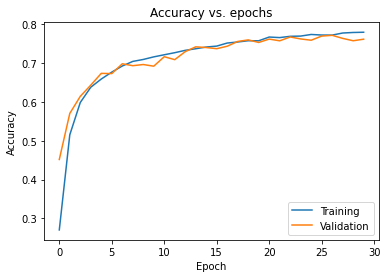

In [14]:
# Plotting the accuracy vs epoch graph

try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

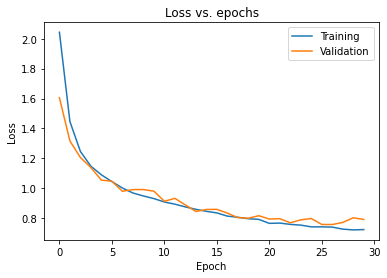

In [15]:
# Plotting the loss vs epoch graph

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [16]:
# Evaluating the model's test loss and accuracy

def get_test_accuracy(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('loss: {acc:0.3f}'.format(acc=test_loss))
    print('accuracy: {acc:0.2f}%'.format(acc=100*test_acc))
    
get_test_accuracy(model, x_test, y_test)

loss: 0.879
accuracy: 73.59%


## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [17]:
# Building the CNN Model

def get_CNN_model(input_shape):
    model = Sequential([
                        Conv2D(filters=16, input_shape=input_shape, kernel_size=(3, 3), 
                        activation='relu', name='conv_1'),
                        MaxPooling2D(pool_size=(2, 2), name='pool_1'),
                        BatchNormalization(name='batch_1'),
                        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', name='conv_2'),
                        Dropout(0.2),
                        MaxPooling2D(pool_size=(3, 3), name='pool_2'),
                        BatchNormalization(name='batch_2'),
                        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', name='conv_3'),
                        Dropout(0.2),
                        Flatten(name='flatten'),
                        Dense(units=128, activation='relu', name='dense_1'),
                        Dropout(0.3),
                        Dense(units=10, activation='softmax', name='dense_2')
                        ])
    opt = tf.keras.optimizers.Adam(learning_rate=0.0003)
    opt2 = tf.keras.optimizers.SGD(lr=6e-3, momentum=0.75)
    opt3 = tf.keras.optimizers.RMSprop(lr=0.0006)
    opt4 = tf.keras.optimizers.Adagrad(lr=0.1)

    model.compile(optimizer=opt4,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [18]:
# Creating an instance of the model and show model summary

model = get_CNN_model(x_train[0].shape)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 30, 30, 16)        160       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 15, 15, 16)        0         
_________________________________________________________________
batch_1 (BatchNormalization) (None, 15, 15, 16)        64        
_________________________________________________________________
conv_2 (Conv2D)              (None, 13, 13, 32)        4640      
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 4, 4, 32)          0         
_________________________________________________________________
batch_2 (BatchNormalization) (None, 4, 4, 32)         

In [19]:
# Creating Tensorflow checkpoints objects functions

def get_checkpoint_every_epoch2():
    checkpoint_every_epoch2_path = 'checkpoints_every_epoch2/checkpoint'
    checkpoint_every_epoch2 = ModelCheckpoint(filepath=checkpoint_every_epoch2_path,
                                             frequency='epoch',
                                             save_weights_only=True,
                                             verbose=1)
    return checkpoint_every_epoch2


def get_checkpoint_best_only2():    
    checkpoint_best_only2_path = 'checkpoints_best_only2/checkpoint'
    checkpoint_best_only2 = ModelCheckpoint(filepath=checkpoint_best_only2_path,
                                           save_weights_only=True,
                                           save_freq='epoch',
                                           monitor='val_accuracy',
                                           save_best_only=True,
                                           verbose=1)
    return checkpoint_best_only2


In [20]:
# Training the model

callbacks2 = [get_checkpoint_every_epoch2(), get_checkpoint_best_only2()]
history = train_model(model, x_train, y_train, epochs=30, batch_size=128, callbacks=callbacks2)

Epoch 1/30

Epoch 00001: saving model to checkpoints_every_epoch2/checkpoint

Epoch 00001: val_accuracy improved from -inf to 0.74875, saving model to checkpoints_best_only2/checkpoint
487/487 - 2s - loss: 0.8902 - accuracy: 0.7160 - val_loss: 0.8147 - val_accuracy: 0.7487
Epoch 2/30

Epoch 00002: saving model to checkpoints_every_epoch2/checkpoint

Epoch 00002: val_accuracy improved from 0.74875 to 0.86805, saving model to checkpoints_best_only2/checkpoint
487/487 - 2s - loss: 0.5504 - accuracy: 0.8313 - val_loss: 0.4447 - val_accuracy: 0.8680
Epoch 3/30

Epoch 00003: saving model to checkpoints_every_epoch2/checkpoint

Epoch 00003: val_accuracy improved from 0.86805 to 0.87396, saving model to checkpoints_best_only2/checkpoint
487/487 - 2s - loss: 0.4958 - accuracy: 0.8477 - val_loss: 0.4248 - val_accuracy: 0.8740
Epoch 4/30

Epoch 00004: saving model to checkpoints_every_epoch2/checkpoint

Epoch 00004: val_accuracy did not improve from 0.87396
487/487 - 2s - loss: 0.4593 - accuracy:

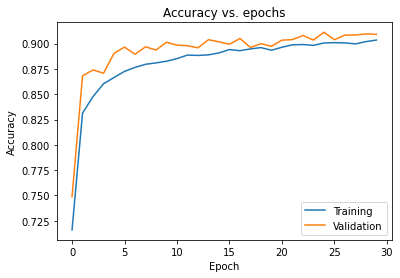

In [21]:
# Plotting the accuracy vs epoch graph

try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

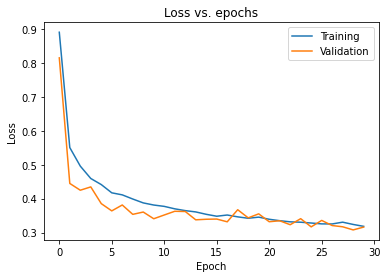

In [22]:
# Plotting the loss vs epoch graph

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [23]:
# Evaluating the model's test loss and accuracy
    
get_test_accuracy(model, x_test, y_test)

loss: 0.329
accuracy: 90.71%


## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [24]:
# Loading weights and calculating loss and accuracy

model = get_MLP_model(x_train[0].shape)
model.load_weights('checkpoints_best_only/checkpoint')
print('MLP model')
get_test_accuracy(model, x_test, y_test)

print('*****************')

model = get_CNN_model(x_train[0].shape)
model.load_weights('checkpoints_best_only2/checkpoint')
print('CNN Model')
get_test_accuracy(model, x_test, y_test)


MLP model
loss: 0.855
accuracy: 74.80%
*****************
CNN Model
loss: 0.330
accuracy: 90.80%


In [25]:
# Calculating model predictions on randomly selected test images

num_x_test = x_test.shape[0]

random_inx = np.random.choice(num_x_test, 5)
random_x_test = x_test[random_inx, ...]
random_y_test = y_test[random_inx, ...]

predictions = model.predict(random_x_test)


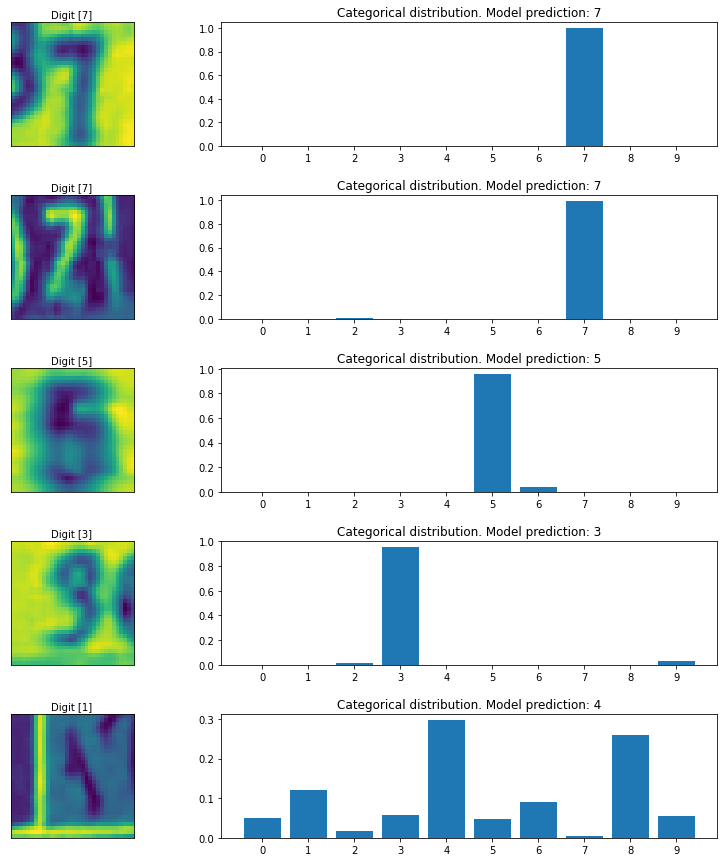

In [26]:
# Ploltting randomly selected test images and showing each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

fig, axes = plt.subplots(5, 2, figsize=(16, 15))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_x_test, random_y_test)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title(f"Categorical distribution. Model prediction: {np.argmax(prediction)}")
    
plt.show()